In [1]:
from dotenv import load_dotenv
from ai_recommend.container import ApplicationContainer
import os
import networkx as nx
from uuid import UUID
import plotly.graph_objects as go

In [2]:
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Load environment variables from .env file in the same directory
load_dotenv(dotenv_path=f"{os.getcwd()}/../.env")

# Initialize application container
container = ApplicationContainer()

# Configure database settings from environment using from_dict()
container.config.from_dict(
    {
        "database": {
            "graph": {
                "host": os.getenv("GRAPH_DB_HOST"),
                "port": os.getenv("GRAPH_DB_PORT", "5432"),
                "username": os.getenv("GRAPH_DB_USER"),
                "password": os.getenv("GRAPH_DB_PASSWORD"),
                "database": os.getenv("GRAPH_DB_DATABASE_NAME"),
            }
        }
    }
)

# Initialize resources after configuration is set
container.init_resources()


# Get resources explicitly from the container
graph_repository = container.repository.graph_repository()

Current Working Directory: /Users/marcelo/Documents/Projects/ai-recommend/notebooks


In [8]:
graph = graph_repository.graph_traverse(start_node_id=UUID("019c6c2c-6496-7eb1-85cd-24cd2fe8e9db"))

In [9]:
G = nx.Graph()
node_by_id = {}


colors_by_label = {"Product": "red", "User": "blue"}
color_map = []

for node in graph:
    id = node["node_id"]
    label = node["node_label"]
    path = node["path"]
    edge_labels_path = node.get("edge_labels_path")
    edge_weights_path = node.get("edge_weights_path")
    props = {"id": id, "label": label, "depth": node["depth"], "path": path}
    node_by_id[id] = props
    G.add_node(id, **props)
    color_map.append(colors_by_label.get(label, "black"))
    G.add_nodes_from([(id, props)])
    if len(path) > 1:
        edge_label = edge_labels_path[-1] if edge_labels_path else None
        edge_weight = edge_weights_path[-1] if edge_weights_path else None
        G.add_edge(path[0], path[-1], label=edge_label, weight=edge_weight)


pos = nx.spring_layout(G, seed=42)

# 2) Build edge traces
edge_x = []
edge_y = []
edge_text_x = []
edge_text_y = []
edge_text = []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    # midpoint for label
    edge_text_x.append((x0 + x1) / 2)
    edge_text_y.append((y0 + y1) / 2)
    label = G.edges[u, v].get("label")
    weight = G.edges[u, v].get("weight")
    if weight is not None:
        edge_text.append(f"{label} ({weight:.2f})")
    else:
        edge_text.append(label or "")

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color="#888"),
    hoverinfo="none",
    mode="lines",
)

edge_label_trace = go.Scatter(
    x=edge_text_x,
    y=edge_text_y,
    mode="text",
    text=edge_text,
    textposition="middle center",
    hoverinfo="none",
)

# 3) Build node traces
node_x = []
node_y = []
node_hover = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_hover.append(str(node))

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    hovertext=node_hover,
    hoverinfo="text",
    marker=dict(
        size=12,
        color=color_map,
        line_width=1,
    ),
)

# 4) Render
fig = go.Figure(data=[edge_trace, edge_label_trace, node_trace])
fig.update_layout(
    showlegend=False,
    margin=dict(l=20, r=20, t=20, b=20),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)
fig.show()

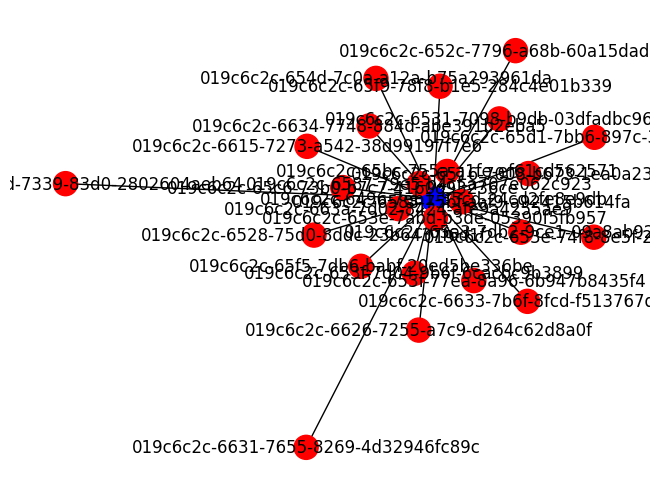

In [10]:
nx.draw(G, with_labels=True, node_color=color_map)